<h1><center>CMSC320 Final Project - Spotify Data Analysis</center></h1>

<h2><center>Created by Ethan Garbow and Neil Shah</center></h2>


<img src="https://storage.googleapis.com/pr-newsroom-wp/1/2018/11/Spotify_Logo_RGB_Green.png" alt="spotlogo" width="400" height="200">

<img src="https://i.pinimg.com/originals/86/ca/33/86ca33be5d38dc0a7b69f04a7965ef85.png" alt="mic" width="200" height="100">



# Introduction

### Motivation

The music industry is on the rise. Over the last few years, annual revenues have consistently been increasing, with a revenue last year of <a href="https://musically.com/2020/01/03/analysis-music-industry-2020-growth/#:~:text=Barring%20a%20major%20surprise%2C%202019,about%20%2421bn%20last%20year.">$20 billion</a>. Music streaming especially has taken off in the past decade. 

<a href="https://djmag.com/news/spotify-reports-total-revenue-744-billion-2019#:~:text=Spotify%20has%20reported%20a%20total,29%25%20when%20compared%20to%202018.">Spotify</a> reported a $7.44 billion revenue in 2019, and competitors like Apple Music and YouTube Music all also have high, growing revenues. 

Clearly, there’s a lot of money to be made within this industry for artists, but only if they manage to become popular. However, it is assumed to be very subjective and unclear as to what makes popular music. Maybe, however, there are hidden trends in the vast amount of data that can be analyzed in order to identify or find leads on what aspects of a song make it popular. 

### What We Are Investigating

The main purpose of this project is to explore trends between popularity and certain sound features/attributes of songs. These attributes include:
- Duration: the duration of the song in milliseconds
- Acousticness: a measure from 0 to 1 indicating if the song is acoustic (1 is high confidence of the song being acoustic)
- Danceability: a measure of how suitable a song is for dancing based on various features (tempo, rhythm, etc.)
- Energy: a measure from 0 to 1 indicating the intensity and activity of the song (energetic songs are usually fast and loud)
- Instrumentalness: a measure indicating whether a song contains no vocals (a higher instrumentalness indicates a higher chance that the song has no vocals at all)
- Liveness: a measure indicating if there is an audience in the song’s recording (a higher value represents a higher probability of being performed live)
- Loudness: a measure of how loud the song is overall in decibels 
- Speechiness: a measure that indicates the presence of spoken words in a song
- Valence: a measure from 0 to 1 indicating how “positive” a song is (happy, cheerful vs sad, depressed)
- Tempo: the estimated overall tempo in beats per minute

Read more about the attributes here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

We will also investigate other trends in the data.

In [21]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from statistics import mean
from sklearn.model_selection import KFold
import statsmodels.formula.api as sm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from scipy import stats as st
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

#Reading in data from SpotifyFeatures.csv into pandas dataframe
Song_Data_Frame = pd.read_csv("SpotifyFeatures.csv")

#Fixing inconsistent data records by making all instances of the same entry consistent
Song_Data_Frame['genre'] = Song_Data_Frame['genre'].apply(lambda x: "Children's Music" if x == "Children’s Music" else x)
Song_Data_Frame['genre'] = Song_Data_Frame['genre'].apply(lambda x: "Reggae" if x == "Reggaeton" else x)

#Dropping A Capella genre from the dataframe
Song_Data_Frame = Song_Data_Frame[Song_Data_Frame['genre'] != 'A Capella']

#Reading in data from SpotifyData.csv (tracks also have a year associated with them) into a pandas dataframe
Song_Data_Frame_Time = pd.read_csv("SpotifyData.csv")

#Merging the two dataframes into one by matching up a tracks by their ID 
Song_Data_Frame_Merged = Song_Data_Frame.merge(Song_Data_Frame_Time[['id','year','explicit']], how = "inner", 
                                               left_on = "track_id", right_on = 'id')

#Creates a dictionary with the artist name mapping to the number of their tracks in the dataframe
artist_freq = Song_Data_Frame['artist_name'].value_counts()

#Adding a new column to store the number of tracks the artist has in the dataframe
Song_Data_Frame['artist_freq'] = Song_Data_Frame['artist_name'].apply(lambda x: int(artist_freq[x]))

#Adding a column to store the decade that track was made to the Song_Data_Frame_Merged dataframe
Song_Data_Frame_Merged['decade'] = Song_Data_Frame_Merged['year'].apply(lambda x: str(x)[2] + '0s' 
                                                                       if x/10 < 200 else
                                                                       "20" + str(x)[2] + '0s')
Song_Data_Frame

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_freq
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,474
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,44
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,39
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,474
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962,8
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969,1
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813,63
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489,21


# Data Curation And Processing

To obtain our data, we used a Spotify CSV file obtained from Kaggle, here: https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

After reading the data into a Pandas dataframe, we noticed that there was an issue with the same genre being listed as two different strings. We used a lambda function to make the two string representations uniform. 

We also dropped A Capella music from the dataset because the genre had too many data inconsistencies and bad observations. 

Once we had clean data, we added an artist frequency column in order to track how many songs each artist in the dataframe appears in. This would allow us to do things like remove “one-hit-wonders” and compare the number of times that an artist appeared. 

We also created a new dataframe called Song_Data_Frame_Merged where we merged our original dataframe with another Spotify CSV that includes dates. Since the date one doesn’t include genre, while our original one does, inner merging the two dataframes gives us the best of both worlds. 

In this dataframe, we also created a decade column so it would be easy to access songs based on the decade they appeared in, rather than only the specific year. This was done using a lambda function and some string manipulation. 



# Data Exploration - Popularity vs Decade

We began our data exploration by making a few plots where decade is the independent variable. 
Below we made a plot of popularity vs decade. As we can see, there seems to be a trend where the more modern the music is, the more popular it is right now. 

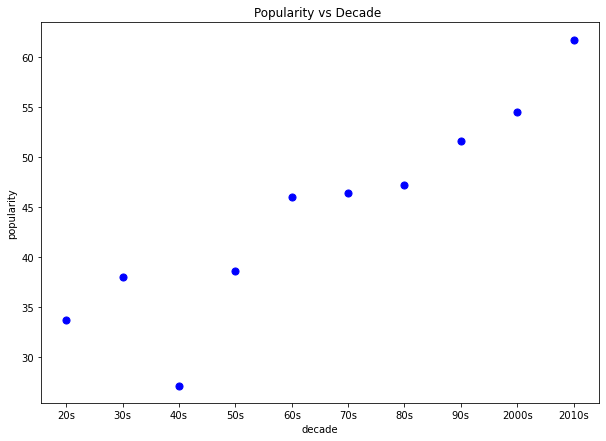

In [2]:
#Grouping the data into groups of the same decade and calculating each group's average values
Decade_Groups = Song_Data_Frame_Merged.groupby(by = 'decade', as_index = False).mean().sort_values(by = 'year')

Decade_Groups.plot(kind='scatter',x='decade',y='popularity', s = 50,
                                                    color='blue', figsize=(10, 7), title = 'Popularity vs Decade ')

## Data Exploration - Danceability vs Decade

Next, we will plot danceability vs decade in order to see how one of our attributes correlates with the popularity trend we see above. As we can see from the graph below, there does seem to be some correlation between popularity and danceability, as both increase over time. Although there are some outliers (1920s and 1930s), the rest of the data appears to be very close to what is observed in the graph above. 


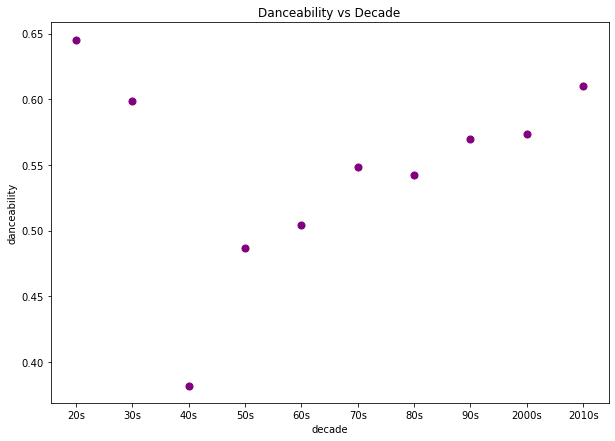

In [3]:
Decade_Groups.plot(kind='scatter',x='decade',y='danceability', s = 50,
                                                    color='purple', figsize=(10, 7), title = 'Danceability vs Decade')

## Data Exploration - Energy vs Decade

In this next graph, we attempt to do the same thing as we did above, but with energy instead of danceability. As can be seen with the graph below, energy also follows a similar trend to decade and danceability. As the decades progress, the average energy for that decade seems to also increase. Can this mean that certain attributes correlate with popularity?

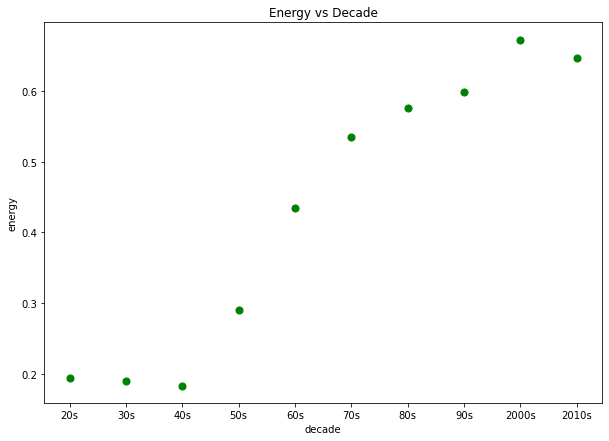

In [4]:
Decade_Groups.plot(kind='scatter',x='decade',y='energy', s = 50,
                                                    color='green', figsize=(10, 7), title = 'Energy vs Decade')

## Data Exploration - An Interesting Observation

Another interesting trend to look at is which genre from each time period is the most popular right now. To accomplish this, we simply iterate through the different decades and isolate the songs in each one. Using this new subset of data, we then group by the genre of music and find the average popularity of each genre. Finally, we can take the most popular entry from this subset to get the currently most popular genre of music from that decade. We can add this to our final dataframe. 

In [5]:
Decade_df = pd.DataFrame()

#looping through the different decades 
for decade in Song_Data_Frame_Merged['decade'].unique():
    
    #Creating a temporary dataframe to store songs of the current decade only
    df = Song_Data_Frame_Merged[Song_Data_Frame_Merged['decade'] == decade]
    #Grouping the songs in the current decade by genre and calculating the mean values for each genre within the decade
    df = df.groupby(by = 'genre', as_index = False).mean().sort_values(by = 'popularity', ascending = False)
    #Extracting the most popular row (genre) from the grouped df 
    Decade_df = Decade_df.append(df.iloc[0])

#Adding back the decade column that was lost in the process above       
Decade_df['decade'] = Decade_df['year'].apply(lambda x: str(x)[2] + '0s' if x/10 < 200 else "20" + str(x)[2] + '0s')

Decade_df.sort_values(by = 'year')[['decade', 'genre', 'popularity']]

,decade,genre,popularity
2,20s,Folk,49.000000
4,30s,Soul,49.500000
5,40s,Soul,51.000000
8,50s,Rock,63.000000
12,60s,Pop,69.214286
15,70s,Pop,68.176471
15,80s,Pop,70.290698
15,90s,Pop,67.146341
15,2000s,Pop,65.871000
15,2010s,Pop,67.919674


## Data Exploration - An Interesting Observation

From the above chart, we can see that the most popular genre per decade right now seems to be Pop. However, from the 1920s to 1950s, other genres are dominant in popularity. Also, from the average popularities listed, we can see that earlier decades of music tend to be less popular now. 











# Data Analysis - Single Variable Correlation

Intuitively, to see what attribute best predicts popularity, we will look at the popularity row of the correlation table. As can be seen in the popularity row, none of the attributes have a strong or even moderate correlation with popularity.

In [6]:
Song_Data_Frame.corr(method = 'spearman')

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_freq
popularity,1.000000,-0.318442,0.256818,0.073337,0.196456,-0.195481,-0.096493,0.335879,-0.012243,0.090643,0.075038,-0.113009
acousticness,-0.318442,1.000000,-0.242710,-0.079535,-0.702987,0.176702,-0.022042,-0.671206,-0.085194,-0.250746,-0.282567,0.114879
danceability,0.256818,-0.242710,1.000000,-0.092735,0.220013,-0.309195,-0.060496,0.284623,0.249989,0.025285,0.529472,-0.144143
duration_ms,0.073337,-0.079535,-0.092735,1.000000,0.034477,0.089617,-0.033749,0.020915,-0.121788,0.008616,-0.146888,-0.064323
energy,0.196456,-0.702987,0.220013,0.034477,1.000000,-0.286692,0.185882,0.814640,0.266819,0.224016,0.417096,-0.124832
instrumentalness,-0.195481,0.176702,-0.309195,0.089617,-0.286692,1.000000,-0.155604,-0.395118,-0.292860,-0.061787,-0.282015,0.047270
liveness,-0.096493,-0.022042,-0.060496,-0.033749,0.185882,-0.155604,1.000000,0.080069,0.189311,-0.010918,0.024906,0.044971
loudness,0.335879,-0.671206,0.284623,0.020915,0.814640,-0.395118,0.080069,1.000000,0.148461,0.223732,0.359347,-0.129398
speechiness,-0.012243,-0.085194,0.249989,-0.121788,0.266819,-0.292860,0.189311,0.148461,1.000000,0.040686,0.150899,0.055460
tempo,0.090643,-0.250746,0.025285,0.008616,0.224016,-0.061787,-0.010918,0.223732,0.040686,1.000000,0.132581,-0.042036


# Data Analysis - Single Variable Correlation

Above we used the Spearman method for calculating the correlation because as detailed here: https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/,
the Pearson method relies on normality whereas the Spearman method does not. Also we chose not to use the Kendall method because it works best with small sample sizes and here we are working with rather large sample sizes.

More on Spearman vs Kendall: https://www.statisticssolutions.com/kendalls-tau-and-spearmans-rank-correlation-coefficient/

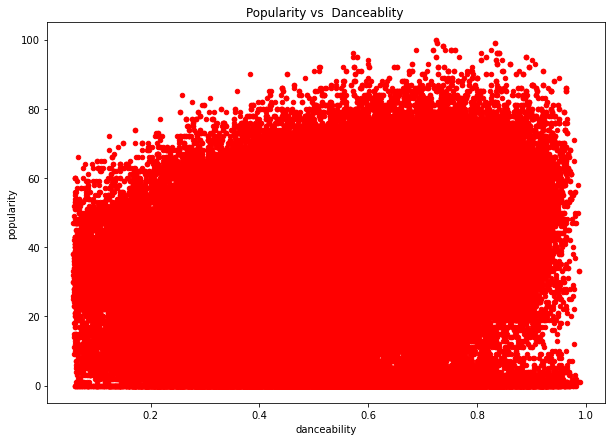

In [22]:
#Graphing popularity vs danceability to show how visually how there is no correlation
Song_Data_Frame.sort_values(by = 'popularity').plot(kind='scatter',x='danceability',y='popularity',
                                                    color='red', figsize=(10, 7), title = 'Popularity vs  Danceablity ')

## Data Analysis - Single Variable Correlation, Genre Averages

Perhaps the reason why there is no strong correlation is because different genres of music have different requirements of attributes to be more or less popular. As can be seen in the graph above, it would seem if we consider the entire dataset of songs, every value of danceability covers the entire range of popularity. Could this be because certain genres require different levels of danceability?


## Data Analysis - Hypothesis Testing

To see if the average popularity of each genre is throwing off the correlation, we will perform a paired t-test to see if the mean popularity of each genre is statistically different than the mean of the population.

In [8]:
for genre in Song_Data_Frame['genre'].unique():
    Genre_df = Song_Data_Frame[Song_Data_Frame['genre'] == genre]['popularity'] 
    print("Genre: "+genre,"\n", st.ttest_1samp(Genre_df, Song_Data_Frame['popularity'].mean()), "\n\n")

Genre: Movie 
 Ttest_1sampResult(statistic=-188.0177117125251, pvalue=0.0) 


Genre: R&B 
 Ttest_1sampResult(statistic=114.50213324911662, pvalue=0.0) 


Genre: Alternative 
 Ttest_1sampResult(statistic=113.94057505851922, pvalue=0.0) 


Genre: Country 
 Ttest_1sampResult(statistic=47.339162565730014, pvalue=0.0) 


Genre: Dance 
 Ttest_1sampResult(statistic=134.2505635130164, pvalue=0.0) 


Genre: Electronic 
 Ttest_1sampResult(statistic=-30.69150991355044, pvalue=3.34262225410574e-197) 


Genre: Anime 
 Ttest_1sampResult(statistic=-165.42652400791238, pvalue=0.0) 


Genre: Folk 
 Ttest_1sampResult(statistic=103.2150793938393, pvalue=0.0) 


Genre: Blues 
 Ttest_1sampResult(statistic=-62.32681829834296, pvalue=0.0) 


Genre: Opera 
 Ttest_1sampResult(statistic=-299.091059350211, pvalue=0.0) 


Genre: Hip-Hop 
 Ttest_1sampResult(statistic=201.4461982971374, pvalue=0.0) 


Genre: Children's Music 
 Ttest_1sampResult(statistic=-23.505460534718946, pvalue=5.6804027059813544e-120) 


Genre

## Data Analysis - Hypothesis Testing

As can be seen above all the p-values are extremely small, so we can reject the null hypothesis which is that the genre popularity mean is similar to the entire population popularity mean. This means we may have to consider genres separately so that the popularity measures are not skewed. 

In [9]:
Genre_Groups = Song_Data_Frame.groupby(by = 'genre', as_index = False).mean()
Genre_Groups.corr(method = 'spearman')

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_freq
popularity,1.000000,-0.539130,0.686087,-0.111304,0.297391,-0.503478,-0.391304,0.644348,0.174783,0.288696,0.305217,-0.407826
acousticness,-0.539130,1.000000,-0.566087,0.276522,-0.865217,0.445217,-0.232174,-0.949565,-0.380000,-0.821739,-0.551304,0.173043
danceability,0.686087,-0.566087,1.000000,-0.183478,0.454783,-0.644348,-0.022609,0.651304,0.703478,0.212174,0.515652,-0.354783
duration_ms,-0.111304,0.276522,-0.183478,1.000000,-0.150435,0.364348,0.050435,-0.340870,-0.294783,-0.224348,-0.294783,-0.300000
energy,0.297391,-0.865217,0.454783,-0.150435,1.000000,-0.506957,0.426957,0.826957,0.464348,0.715652,0.478261,-0.211304
instrumentalness,-0.503478,0.445217,-0.644348,0.364348,-0.506957,1.000000,-0.244348,-0.598261,-0.556522,-0.202609,-0.492174,0.187826
liveness,-0.391304,-0.232174,-0.022609,0.050435,0.426957,-0.244348,1.000000,0.150435,0.409565,0.226957,0.158261,0.190435
loudness,0.644348,-0.949565,0.651304,-0.340870,0.826957,-0.598261,0.150435,1.000000,0.436522,0.717391,0.593913,-0.202609
speechiness,0.174783,-0.380000,0.703478,-0.294783,0.464348,-0.556522,0.409565,0.436522,1.000000,0.046087,0.277391,0.112174
tempo,0.288696,-0.821739,0.212174,-0.224348,0.715652,-0.202609,0.226957,0.717391,0.046087,1.000000,0.505217,-0.101739


## Data Analysis - Single Variable Correlation, Genre Averages

The above code was written to try to solve the problem of comparing individual songs of different genres. To do this, we created a new dataframe, Genre_Groups, by making each row correspond to the average entry of each genre in the Song_Data_Frame. This was done so a correlation could be made between each genre's popularity and its attributes instead of individual songs. 

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

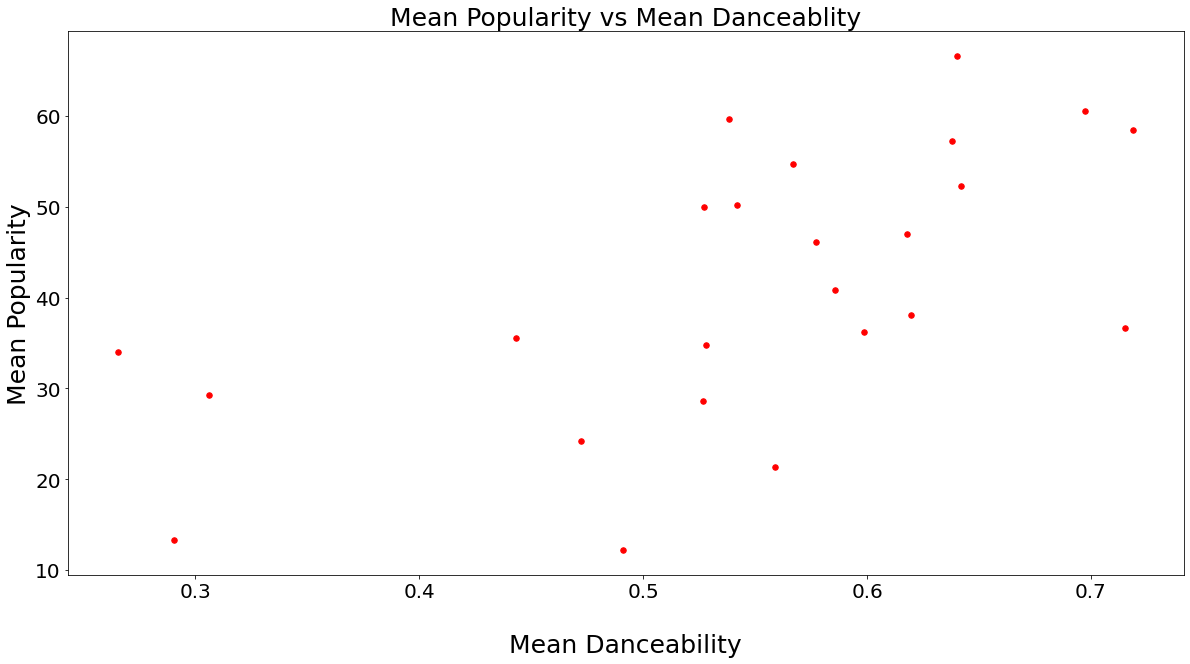

In [10]:
#Starting to see a trend form, but it still unclear
Genre_Groups.plot(kind='scatter',x='danceability',y='popularity', s = 30,
                                                    color='red', figsize=(20, 10))
plt.title('Mean Popularity vs Mean Danceablity', size = 25)
plt.xlabel('\nMean Danceability', size = 25)
plt.ylabel('Mean Popularity', size = 25)
plt.xticks(size = 20)
plt.yticks(size = 20)

## Data Analysis - Single Variable Correlation, Genre Averages

It turns out the fix we attempted above (Genre_Groups), improved the correlation between popularity and other attributes. For example, as shown above, the correlation between genre mean popularity and genre mean danceability is about .68, so not strongly correlated but an improvement.   

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

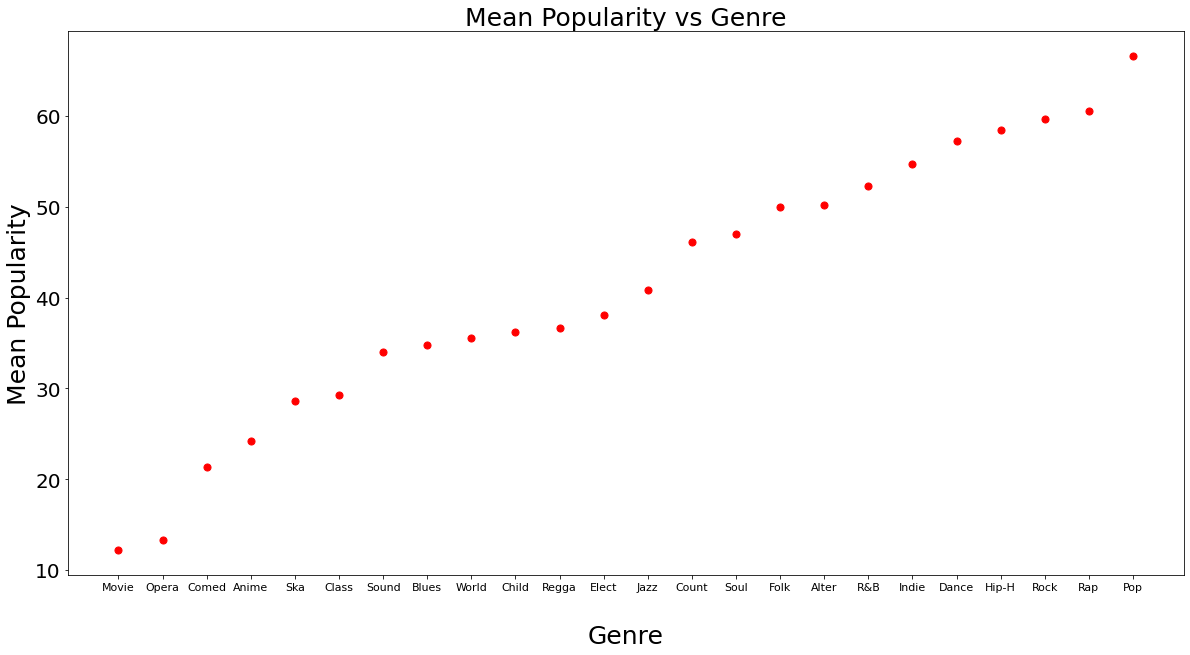

In [11]:
#Mean popularities are different per genre so perhaps different levels of attributes contribute more to one genre's popularity
#than another's.
Genre_Groups['genre'] = Genre_Groups['genre'].apply(lambda x: x[0:5])

Genre_Groups.sort_values(by = 'popularity').plot(kind='scatter',x='genre',y='popularity', s = 50,
                                                    color='red', figsize=(20, 10), title = 'Popularity vs  Genre ')
plt.title('Mean Popularity vs Genre', size = 25)
plt.xlabel('\nGenre', size = 25)
plt.ylabel('Mean Popularity', size = 25)
plt.xticks(size = 11)
plt.yticks(size = 20)

## Data Analysis - Single Variable Correlation, Genre Averages

The above graph illustrates the large differences in average popularity between different genres. This leads us to believe that we may need to instead correlate popularity within a specific genre to attributes also within that specific genre. This way, attributes in one genre that correlate to its popularity won’t affect how those same attributes affect the popularity of another genre. 

In [25]:
#Creating a correlation table with each row representing the popularity correlation within only one genre
corr_Data_Frame = pd.DataFrame()
row = pd.DataFrame()

#Looping through each genre
for genre in Song_Data_Frame['genre'].unique():
    #Creating a dataframe consisting of songs from only one genre
    row = pd.DataFrame(Song_Data_Frame[Song_Data_Frame['genre'] == genre].corr(method = 'spearman').iloc[0])
    row = row.transpose().reset_index()
    row['index'] = genre
    #Extracting the popularity row of the correlation table for the current genre and appending it to the overall 
    #correlation table
    corr_Data_Frame = corr_Data_Frame.append(row, ignore_index = True) 
    
corr_Data_Frame = corr_Data_Frame.rename(columns = {'index' : 'Genre Popularity corr'})
corr_Data_Frame


,Genre Popularity corr,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_freq
0,Movie,1.0,0.064102,-0.225412,-0.048466,-0.096072,0.116404,-0.066327,-0.037824,-0.090736,-0.057661,-0.235618,-0.200685
1,R&B,1.0,-0.040363,0.069235,0.004961,0.046318,-0.046109,-0.020604,0.103565,-0.006821,-0.014078,0.040589,0.271813
2,Alternative,1.0,0.026456,0.079119,0.022872,-0.027904,0.002395,-0.033014,0.003666,-0.000582,-0.052023,0.067235,0.166060
3,Country,1.0,-0.023651,0.015430,-0.003592,0.040467,-0.033412,-0.053613,0.034259,0.029814,-0.012348,0.051309,0.133060
4,Dance,1.0,0.068616,0.075706,-0.092367,-0.036819,-0.097416,-0.039972,0.051984,0.020578,-0.029906,0.034223,0.034681
5,Electronic,1.0,0.052309,0.061447,0.048542,-0.069857,-0.071024,-0.057068,-0.039945,-0.080689,-0.041389,0.034769,0.073876
6,Anime,1.0,-0.109071,0.067794,0.188367,0.163121,-0.264236,0.025105,0.238972,0.031799,0.031401,0.104361,-0.041559
7,Folk,1.0,-0.031274,0.044492,0.019226,0.057994,-0.042297,-0.054183,0.041809,-0.019181,-0.012685,0.020760,0.099505
8,Blues,1.0,-0.022775,-0.039145,-0.077957,0.009470,-0.052598,-0.048737,-0.009931,-0.047958,-0.003525,-0.022326,0.224583
9,Opera,1.0,-0.010799,-0.094306,0.040397,0.034131,0.064625,-0.084985,0.101518,-0.133788,-0.018127,-0.031718,-0.011185


## Data Analysis - Single Variable Correlation Within Each Genre

In the above dataframe, each row corresponds to the popularity correlation row of the dataframe consisting of only songs from that genre. In other words, we are able to observe the popularity correlation within a specific genre for all genres, without having one genre’s attributes affect another. 

This was done by creating a dataframe consisting of only songs from each genre, creating a correlation table for that dataframe, extracting the popularity correlation from that genre’s correlation table, and appending it to the correlation dataframe seen above. 

As we can see above, this does not dramatically increase the correlations between the attributes and popularity. This could be due to the fact that the fanbase of each artist within each genre likes different attributes. We try accounting for this below. 

In [26]:
#Creating a correlation table with each row representing the popularity correlation within only one artists works
corr_Data_Frame = pd.DataFrame()
row = pd.DataFrame()

#Creating a temporary dataframe consisting of songs by artists that appear more than 30 times in the data set
temp = Song_Data_Frame[Song_Data_Frame['artist_freq'] > 30]

#Looping through each artist 
for artist in temp['artist_name'].unique():
    #Creating a dataframe consisting of songs from only one artist
    row = pd.DataFrame(Song_Data_Frame[Song_Data_Frame['artist_name'] == artist].corr(method = 'spearman').iloc[0])
    row = row.transpose().reset_index()
    row['index'] = artist
    #Extracting the popularity row of the correlation table for the current artist and appending it to the overall 
    #correlation table
    corr_Data_Frame = corr_Data_Frame.append(row, ignore_index = True) 

corr_Data_Frame = corr_Data_Frame.rename(columns = {'index' : 'Artist Popularity corr'})

#Calculating the average correlation values between all the artists (on average how well does popularity
#correlate with the other attributes)
print("Mean Correlation With Popularity:\n\n" + 
      str(np.absolute(corr_Data_Frame.drop(columns = ['artist_freq', 'Artist Popularity corr']).dropna()).mean()))
print("\n\nVariance of Correlation With Popularity:\n\n" + 
      str(np.absolute(corr_Data_Frame.drop(columns = ['artist_freq', 'Artist Popularity corr']).dropna()).var()))

Mean Correlation With Popularity:

popularity          1.000000
acousticness        0.181532
danceability        0.180221
duration_ms         0.179284
energy              0.182047
instrumentalness    0.180534
liveness            0.164191
loudness            0.199645
speechiness         0.171395
tempo               0.153498
valence             0.175511
dtype: float64


Variance of Correlation With Popularity:

popularity          0.000000
acousticness        0.020980
danceability        0.019572
duration_ms         0.018728
energy              0.022079
instrumentalness    0.019669
liveness            0.018032
loudness            0.024820
speechiness         0.017625
tempo               0.015749
valence             0.019256
dtype: float64


## Data Analysis - Single Variable Correlation Within Each Artists' Works

Above we created another correlation dataframe, but this time each row corresponds to only songs of a particular artist. To only include artists with enough data points, we only include artists who appear in the dataset more than 30 times. This removes the issue with having “one-hit-wonder” artists appearing in our data, which can throw off popularity due to their one popular song. We did this using the artist_freq column.

Since the dataframe has 1000s of rows, we took the average to see how popularity correlation measured in this way performs on average across the many artists.

As can be seen by the results above, there is still no strong correlation between a single variable and popularity. Perhaps this is because it is not one attribute but a combination of attributes that can predict popularity?

# Data Analysis - Multivariable Correlation

Below we want to see if we can model popularity based on multiple interaction terms. To do this, we use statsmodels’s OLS feature.

More on OLS: https://en.wikipedia.org/wiki/Ordinary_least_squares#:~:text=OLS%20chooses%20the%20parameters%20of,predicted%20by%20the%20linear%20function

More on the stats models api: https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html

In [27]:
modelString = '''popularity ~ acousticness * danceability * duration_ms * energy * instrumentalness * liveness * 
loudness * speechiness * tempo * valence'''

model = sm.ols(modelString, data = Song_Data_Frame).fit()

print("R-squared: " + str(model.rsquared) + "\tR-squared-adj: " + str(model.rsquared_adj) + "\n")

R-squared: 0.32789870926404197	R-squared-adj: 0.3251657764440695



## Data Analysis - Multivariable Correlation Within Entire Data Set

Above we attempted to model popularity using many interaction terms. As can be seen by the R^2 value, the model does not fit well, so perhaps we have to again, try accounting for genre.

## Data Analysis - Multivariable Correlation Within Each Genre

Maybe we can model popularity based on the interaction between the other attributes within each genre. This way, we can observe the R^2 value per genre, rather than over the entire dataset’s songs. 

In [28]:
modelString = '''popularity ~ acousticness * danceability * duration_ms * energy * instrumentalness * liveness * 
loudness * speechiness * tempo * valence'''

#Looping through the genres
for genre in Song_Data_Frame['genre'].unique():
    #Creating a model for popularity only considering songs of the current genre
    model = sm.ols(modelString, data = Song_Data_Frame[Song_Data_Frame['genre'] == genre]).fit()
    print(genre + " R-squared: " + str(model.rsquared) + "\nR-squared-adj: " + str(model.rsquared_adj) + "\n")

Movie R-squared: 0.2212812489403153
R-squared-adj: 0.12321121580772654

R&B R-squared: 0.12364467779868649
R-squared-adj: 0.032738681326784924

Alternative R-squared: 0.12647350866151974
R-squared-adj: 0.035799980601000536

Country R-squared: 0.10546220992464828
R-squared-adj: 0.01732426129561615

Dance R-squared: 0.1405839698561504
R-squared-adj: 0.05006740410983457

Electronic R-squared: 0.12458233184874024
R-squared-adj: 0.033111549465636436

Anime R-squared: 0.2046278287100326
R-squared-adj: 0.11630808872471299

Folk R-squared: 0.11511533011572528
R-squared-adj: 0.025851567536823716

Blues R-squared: 0.15259579239581977
R-squared-adj: 0.060430040431987964

Opera R-squared: 0.1764332149315787
R-squared-adj: 0.08662968337823707

Hip-Hop R-squared: 0.13066007325283813
R-squared-adj: 0.045974108018878024

Children's Music R-squared: 0.6685127055350488
R-squared-adj: 0.6465716431945694

Rap R-squared: 0.12539799259827455
R-squared-adj: 0.04036002254542648

Indie R-squared: 0.12162196760

## Data Analysis - Multivariable Correlation Within Each Artists' Works

From our resulting R^2 values within each genre, we can see that the vast majority of the genres have a poor fit between their attributes and their popularity. Instead, we may need to go another level deeper, and find out how well these attributes can model popularity within each artist. To do this, we only observe artists who appear more than 100 times in the dataset, sample 20 of these artists randomly, and find the R^2 value corresponding to each of them. 

In [29]:
modelString = '''popularity ~ acousticness * danceability * duration_ms * energy * instrumentalness * liveness * 
loudness * speechiness * tempo * valence'''

#Creating a temporary dataframe consisting of songs by artists that appear more than 100 times in the data set
temp = Song_Data_Frame[Song_Data_Frame['artist_freq'] > 100]

#Looping through the aritsts
for artist in temp.drop_duplicates(subset=['artist_name'])['artist_name'].sample(20):
    #Creating a model for popularity only considering songs of the current artist
    model = sm.ols(modelString, data = Song_Data_Frame[Song_Data_Frame['artist_name'] == artist]).fit()
    #Some artists have invalid values causing invalid results from the model generation, this prevents those from printing
    if str(model.rsquared_adj) != 'nan' and float(model.rsquared_adj) != None and str(model.rsquared_adj) != '-inf':
        print(artist + " R-squared: " + str(model.rsquared) + "\nR-squared-adj: " + str(model.rsquared_adj) + "\n")

Aretha Franklin R-squared: 0.9707881908039923
R-squared-adj: 0.9403244469281556

Hollywood Undead R-squared: 0.8488175467601445
R-squared-adj: 0.7660650460393815

Florida Georgia Line R-squared: 0.9995950591747141
R-squared-adj: 0.999226931151727

Thievery Corporation R-squared: 0.9987028210666625
R-squared-adj: 0.9968723574607308

Luciano Pavarotti R-squared: 0.9997929530244292
R-squared-adj: 0.9984954586441853

Wisin & Yandel R-squared: 1.0
R-squared-adj: 1.0

Lynyrd Skynyrd R-squared: 0.9966907357918088
R-squared-adj: 0.9887278187908487

Tomaso Albinoni R-squared: 0.9290712389204479
R-squared-adj: -0.5958971242899234

MARINA R-squared: 0.7672691887280374
R-squared-adj: 0.5867021799825491

Arctic Monkeys R-squared: 1.0
R-squared-adj: 1.0

John Mayer R-squared: 1.0
R-squared-adj: 1.0

The Neighbourhood R-squared: 0.9015294337443526
R-squared-adj: 0.8544727029673175

Chris Brown R-squared: 0.9992183778669018
R-squared-adj: 0.998688350841024

Smino R-squared: 0.8740544831664807
R-square

## Data Analysis - Multivariable Correlation Within Each Artists' Work

Clearly, this yields significantly better results. Most of the R^2 values are close to 1, indicating a good fit in the model between the interaction terms and popularity. While this does not guarantee a good set of predictors, the above may indicate that while the attributes discussed may not be a good predictor of popularity of a song in general, or of a song within a genre, it may be possible to predict the popularity of a song in the scope of the artist’s other work. In other words, it may be possible to predict how popular a particular artist’s song will be compared to their other songs based on these attributes. This could be due to the fact that the fanbase of the artist consistently enjoys specific combinations of qualities of the artist’s songs, and so the songs that contain these qualities tend to be more popular compared to other songs by the artist that don’t have these characteristics. 

Before testing if we can effectively predict a song’s popularity within their artist’s work, however, we can first run the same model as before on all artists to confirm that on average we get a high R^2 value. Since there are too many artists to view effectively at once, we will instead find the mean R^2 of 100 artists and use this.

In [30]:
modelString = '''popularity ~ acousticness * danceability * duration_ms * energy * instrumentalness * liveness * 
loudness * speechiness * tempo * valence'''

Rsquared_Total = 0
Adj_Rsquared_Total = 0
counter = 0

#Creating a temporary dataframe consisting of songs by artists that appear more than 100 times in the data set
temp = Song_Data_Frame[Song_Data_Frame['artist_freq'] > 100]

#Looping through the aritsts
for artist in temp.drop_duplicates(subset=['artist_name'])['artist_name'].sample(100):
    #Creating a model for popularity only considering songs of the current artist
    model = sm.ols(modelString, data = temp[temp['artist_name'] == artist]).fit()
    #Some artists have invalid values causing invalid results from the model generation, this prevents those from printing
    if str(model.rsquared_adj) != 'nan' and float(model.rsquared_adj) != None and str(model.rsquared_adj) != '-inf':
        counter = counter + 1
        Rsquared_Total = Rsquared_Total + float(model.rsquared)
        Adj_Rsquared_Total = Adj_Rsquared_Total + float(model.rsquared_adj)

#Printing average R-squared and R-squared-adj values
print("R-squared average: " + str(Rsquared_Total/counter))
print("\nR-squared-adj average: " + str(Adj_Rsquared_Total/counter))

R-squared average: 0.9811698929701467

R-squared-adj average: 0.8701362813903176


## Data Analysis - Multivariable Correlation Within Each Artists' Work

We get an average R^2 value of 0.97. This is a sign that for most artists, the model of all attributes interacting to popularity has a good fit. Due to this fact, we can try creating a prediction model using Random Forest, K-Nearest Neighbors, and Linear Regression models. 


# Machine Learning - Predicting An Artist's Song's Popularity 

We will train each of the models based on the attributes discussed, and try to predict popularity within a small margin of error. The margin we will use will be the difference between that artist’s highest popularity and lowest popularity songs, multiplied by 0.05. This means for the model to be correct in our 10-Fold Cross Validation test, the predicted popularity of the song must fall within 5% of the artist’s total popularity range from its actual popularity. In the 10-Fold Cross Validation test, we will split 90% of the artist’s music into a training dataset to train the model on, and 10% of the artist’s music into a testing dataset to test our model on. We will run this 10 times, where each 10% portion of the artist’s songs will be used as testing data at some point. We will then find the average accuracy between all 10 iterations of this test to see our average accuracy per model for that artist. To start, we can use the following three well-known artists:
- Meek Mill (rap and hip-hop)
- Taylor Swift (pop) 
- Wiz Khalifa (rap)

For more on how K-Nearest Neighbors algorithm works: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

For more on how Random Forest algorithm works: https://www.wikiwand.com/en/Random_forest

For more on how sklearn's Linear Regression algorithm works: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [31]:
#This function returns the ratio of accepted predicted values to total values
#If a predicted value is within the specified accept range, it will count as a success
def score(predicted, actual, accept_range):
    count = 0
    for i in range(len(predicted)):
        if abs(predicted[i] - actual[i]) < accept_range:
            count += 1
    return count / len(actual)


Artist_List = ['Meek Mill', 'Taylor Swift', 'Wiz Khalifa']

cols_to_drop = ['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'key', 'mode', 'time_signature', 'artist_freq']

#Looping through artists
for artist in Artist_List:
    #Creating a temporary dataframe of only songs by the current artist
    Artist_Data_Frame = Song_Data_Frame[Song_Data_Frame['artist_name'] == artist]
    #Extracting the predictors columns
    x = Artist_Data_Frame.drop(columns = cols_to_drop).values
    #Extracting the actual popularity values
    y = Artist_Data_Frame['popularity'].values

    RF_scores = []
    KNN_scores = []
    reg_scores = []
    
    #Creating the partition indexing for k-fold
    Folds = KFold(n_splits=10, shuffle=False)
    
    #Calculating the accept range for this particular artist
    accept_range = .05*(y.max() - y.min())

    #Looping through the partitions for k-fold
    for train, test in Folds.split(x):

        #Random Forrest training and predicting
        RF_class = RFC()
        RF_class.fit(x[train], y[train])
        RF_predicted = RF_class.predict(x[test])
        RF_scores.append(score(RF_predicted, y[test], accept_range))

        #k-NN classification training and predicting
        KNN_class = KNN(n_neighbors = 1) #k_NN
        KNN_class.fit(x[train], y[train])
        KNN_predicted = KNN_class.predict(x[test])
        KNN_scores.append(score(KNN_predicted, y[test], accept_range))

        #linear regression from sklearn
        reg = LinearRegression().fit(x[train], y[train])
        reg_predicted = reg.predict(x[test])
        reg_scores.append(score(reg_predicted, y[test], accept_range))
 
    #Printing average score for each machine learning algorithm for the current artist
    print(artist+" RF average score: " +str(mean(RF_scores))+ " STD Error: "+ str(st.sem(RF_scores)))
    print("\n"+artist+" KNN average score: "+ str(mean(KNN_scores))+ " STD Error: "+ str(st.sem(KNN_scores)))
    print("\n"+artist+" reg average score: "+ str(mean(reg_scores))+ " STD Error: "+ str(st.sem(reg_scores))+"\n\n")

Meek Mill RF average score: 0.9666666666666667 STD Error: 0.03333333333333333

Meek Mill KNN average score: 0.9666666666666667 STD Error: 0.03333333333333333

Meek Mill reg average score: 0.22047619047619046 STD Error: 0.0769081608500775


Taylor Swift RF average score: 0.7663398692810457 STD Error: 0.12160712839394489

Taylor Swift KNN average score: 0.7552287581699346 STD Error: 0.12171656260076548

Taylor Swift reg average score: 0.15947712418300652 STD Error: 0.055334688474651464


Wiz Khalifa RF average score: 0.9526315789473684 STD Error: 0.04736842105263158

Wiz Khalifa KNN average score: 0.9526315789473684 STD Error: 0.04736842105263158

Wiz Khalifa reg average score: 0.21710526315789475 STD Error: 0.053437182481205915




## Machine Learning - Predicting An Artist's Song's Popularity

From this testing, we see that our Random Forest model had the most accuracy throughout all three artists, closely followed by the K-Nearest Neighbors model. For both Meek Mill and Wiz Khalifa, the two models had over a 95% accuracy. For Taylor Swift, while the models were not quite as accurate, we still obtained over a 75% accuracy in popularity prediction, which is still a good result. This leads us to believe that maybe it is possible to accurately predict a song’s popularity within that artist’s work using the attributes discussed above. To test this theory, we can try this model on a sample of 100 artists from the entire dataset for artists who appear more than 100 times. We will then find the average accuracy between all the artists for each model.

In this 10-Fold CV Test, we will use a margin of error of 7.5 popularity points because the range of popularity points can be larger or smaller depending on the artist, so it would be fair to have a general scale for popularity. For example, for a specific artist, the output could output a popularity of 95 instead of 96, but if the range of this artist’s popularity is small enough, then this could be an incorrect prediction even though the model is very close.

In [32]:
KNN_average = []
RF_average = []
reg_average = []


#Creating a temporary dataframe consisting of songs by artists that appear more than 100 times in the data set
temp = Song_Data_Frame[Song_Data_Frame['artist_freq'] > 100]

counter = 0

cols_to_drop = ['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'key', 'mode', 'time_signature', 'artist_freq']

#Looping through the artists
for artist in temp.drop_duplicates(subset=['artist_name'])['artist_name'].sample(100):
    
    #Creating a temporary dataframe of only songs by the current artist
    Artist_Data_Frame = temp[temp['artist_name'] == artist].dropna()
    
    counter = counter + 1

    #Extracting the predictors columns
    x = Artist_Data_Frame.drop(columns = cols_to_drop).values
    #Extracting the actual popularity values
    y = Artist_Data_Frame['popularity'].values

    RF_scores = []
    KNN_scores = []
    reg_scores = []
    
    #Creating the partition indexing for k-fold
    Folds = KFold(n_splits=10, shuffle=False)
    
    accept_range = 7.5

    #Looping through the partitions for k-fold
    for train, test in Folds.split(x):
        
        #Random Forrest training and predicting
        RF_class = RFC()
        RF_class.fit(x[train], y[train])
        RF_predicted = RF_class.predict(x[test])
        RF_scores.append(score(RF_predicted, y[test], accept_range))
        
        #k-NN classification training and predicting
        KNN_class = KNN(n_neighbors = 1) #k_NN
        KNN_class.fit(x[train], y[train])
        KNN_predicted = KNN_class.predict(x[test])
        KNN_scores.append(score(KNN_predicted, y[test], accept_range))
        
        #linear regression from sklearn
        reg = LinearRegression().fit(x[train], y[train])
        reg_predicted = reg.predict(x[test])
        reg_scores.append(score(reg_predicted, y[test], accept_range))
    
    #Appending each machine learning algorithms average score for the current artist
    KNN_average.append(mean(KNN_scores))
    RF_average.append(mean(RF_scores))
    reg_average.append(mean(reg_scores))

#Printing the average of the average scores for each machine learning algorithm
print("\n\nRF average score: ", mean(RF_average), " STD Error: ", st.sem(RF_average))
print("\nKNN average score: ", mean(KNN_average), " STD Error: ", st.sem(KNN_average))
print("\nreg average score: ", mean(reg_average), " STD Error: ", st.sem(reg_average))



RF average score:  0.8039902212784716  STD Error:  0.017936814890590593

KNN average score:  0.7649768319037875  STD Error:  0.02112231770428581

reg average score:  0.6650081923087369  STD Error:  0.01676721600419694


# Concluding Thoughts

From the test conducted above, we can see that we can get a decent prediction of popularity based on the song attributes. Although, as seen before, the prediction is more accurate for certain artists compared to others. This could mean that a certain artist’s fanbase prefers a combination of specific attributes in the artist’s music more than another artist’s fanbase, who may prefer different types of music from them.

Earlier, during our data exploration, we noticed that there might be some correlation between certain attributes and popularity. Through analysis using single variable correlation, we found that there is no strong relationship between a single variable and popularity. However, through the use of interaction terms, we found that we can get a decent prediction of popularity using these attributes within each artist.

Since our initial guess that popularity could be predicted overall was incorrect, we had to continuously narrow our scope from overall popularity, to popularity within a genre, and finally to our most accurate model of popularity within an artist’s work.